Fully Deterministic Environment -- 0% Stochasticity

Algorithms (3): DQN, PPO, A2C

Seeds values = [0, 42, 1729, 123, 196]

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pickle

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### DQN with multiple seeds values 

DQN - Architecture

- Input: Current state (position, velocity in MountainCar)
- Output: Q-value for each possible action (left, stay, right)
- Structure: 2 hidden layers with 128 neurons each, using ReLU activation

In [2]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
    
    def forward(self, x):
        return self.network(x)

DQN - Replay Buffer

- Purpose: Stores past experiences (state, action, reward, next_state, done)
- Why: Breaking correlation between consecutive samples improves learning stability
- Capacity: Stores up to 100,000 experiences, automatically removes oldest when full
- Sampling: Randomly selects batches for training to break temporal correlations

In [3]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards), 
                np.array(next_states), np.array(dones))
    
    def __len__(self):
        return len(self.buffer)

DQN - Agent

- Initialize the dqn agent with:
    - Two networks: Policy network (being trained) and target network (stable reference)
    - Epsilon-greedy exploration: Starts exploring randomly (ε=1.0), gradually exploits learned policy (ε→0.01)
    - Discount factor (γ=0.99): Values future rewards at 99% of immediate rewards
    - Adam optimizer: Efficient gradient descent algorithm

- Decides which action to take: (select_action)

    - During training: With probability ε, choose random action (exploration)
    - Otherwise: Choose action with highest Q-value (exploitation)
    - Balance: Early on, explores randomly; later, relies on learned policy

- Trains the network to predict accurate Q-values:(train_step)
    - Sample batch: Get random experiences from replay buffer
    - Current Q-values: What the policy network currently predicts
    - Target Q-values: What Q-values should be (Bellman equation: r + γ·max Q(s',a'))
    - Loss: Difference between current and target Q-values
    - Update: Adjust network weights to minimize loss

- Sync Target Network & Decay Epsilon: 
    - update_target_network(): Periodically syncs target network with policy network (stability)
    - decay_epsilon(): Reduces exploration over time (explore early, exploit later)

In [4]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.0005, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.997):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        
        # Networks
        self.policy_net = DQN(state_dim, action_dim).to(device)
        self.target_net = DQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer()
        
    def select_action(self, state, training=True):
        if training and random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.policy_net(state_tensor)
                return q_values.argmax().item()
    
    def train_step(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return None
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(batch_size)
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)
        
        # Current Q values
        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1))
        
        # Target Q values
        with torch.no_grad():
            next_q_values = self.target_net(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values
        
        # Loss
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

DQN - Training Fct

- Sets up training for one seed.

    - Seeds: Ensures reproducible results by setting all random number generators
    - Environment: Creates MountainCar environment
    - Metrics: Initializes lists to track performance over time

- The main training loop.

    - Reset: Start new episode
    - For each step:

        - Agent selects action (explore or exploit)
        - Environment executes action, returns new state and reward
        - Store experience in replay buffer
        - Train network on random batch from replay buffer
        - Accumulate reward
    
    - Repeat until episode ends (success or max steps)

- Post-episode bookkeeping.

    - Records: Save episode statistics
    - Success tracking: Records when agent first reaches success threshold (-110)
    - Target network: Updates every 10 episodes for stability
    - Epsilon decay: Reduces exploration rate
    - Progress: Shows average return and current epsilon
    - Returns: Dictionary with all training data for analysis

In [ ]:
def train_dqn(seed, num_episodes=1000, max_steps=200, batch_size=64, 
              target_update_freq=10, success_threshold=-110):
    """
    Train DQN agent on MountainCar-v0
    
    Args:
        seed: Random seed for reproducibility
        num_episodes: Number of training episodes
        max_steps: Maximum steps per episode
        batch_size: Batch size for training
        target_update_freq: Frequency of target network updates
        success_threshold: Return threshold for considering success
    """
    # Set seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Create environment
    env = gym.make('MountainCar-v0')
    env.reset(seed=seed)
    
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # Create agent
    agent = DQNAgent(state_dim, action_dim)
    
    # Tracking metrics
    episode_returns = []
    episode_lengths = []
    losses = []
    steps_to_success = None
    
    # Training loop
    progress_bar = tqdm(range(num_episodes), desc=f"Seed {seed}")
    
    for episode in progress_bar:
        state, _ = env.reset()
        episode_return = 0
        episode_loss = []
        
        for step in range(max_steps):
            # Select and perform action
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store transition
            agent.replay_buffer.push(state, action, reward, next_state, done)
            
            # Train
            loss = agent.train_step(batch_size)
            if loss is not None:
                episode_loss.append(loss)
            
            episode_return += reward
            state = next_state
            
            if done:
                break
        
        # Update metrics
        episode_returns.append(episode_return)
        episode_lengths.append(step + 1)
        if episode_loss:
            losses.append(np.mean(episode_loss))
        
        # Check for first success
        if steps_to_success is None and episode_return >= success_threshold:
            steps_to_success = sum(episode_lengths)
        
        # Update target network
        if episode % target_update_freq == 0:
            agent.update_target_network()
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Update progress bar
        avg_return = np.mean(episode_returns[-100:])
        progress_bar.set_postfix({
            'avg_return': f'{avg_return:.2f}',
            'epsilon': f'{agent.epsilon:.3f}'
        })
    
    env.close()
    
    return {
        'seed': seed,
        'episode_returns': episode_returns,
        'episode_lengths': episode_lengths,
        'losses': losses,
        'steps_to_success': steps_to_success,
        'final_avg_return': np.mean(episode_returns[-100:])
    }

DQN - Multiple Seeds Velues

- Trains multiple agents with different random seeds.

    - Why multiple seeds? DQN is stochastic - results vary based on random initialization, exploration, and sampling. Multiple seeds give statistical confidence.
    - Trains 5 agents independently
    - Saves results to file for later analysis
    - Purpose: Evaluate algorithm reliability and robustness

In [10]:
# Configuration
SEEDS = [0, 42, 1729, 123, 196]  
NUM_EPISODES = 1000
SUCCESS_THRESHOLD = -110
'''worse -200, so -110 means agent is reaching the goal faster and more consistently, on average'''

# Train with multiple seeds
results = []

for seed in SEEDS:
    print(f"\n{'='*60}")
    print(f"Training with seed {seed}")
    print(f"{'='*60}")
    
    result = train_dqn(
        seed=seed,
        num_episodes=NUM_EPISODES,
        success_threshold=SUCCESS_THRESHOLD
    )
    results.append(result)
    
    print(f"Final average return: {result['final_avg_return']:.2f}")
    print(f"Steps to success: {result['steps_to_success']}")

# Save results
with open('dqn_results.pkl', 'wb') as f:
    pickle.dump(results, f)

print("\n" + "="*60)
print("Training completed for all seeds!")
print("="*60)


Training with seed 0


Seed 0:   0%|          | 0/1000 [00:00<?, ?it/s]

Final average return: -149.31
Steps to success: 152801

Training with seed 42


Seed 42:   0%|          | 0/1000 [00:00<?, ?it/s]

Final average return: -171.95
Steps to success: 193099

Training with seed 1729


Seed 1729:   0%|          | 0/1000 [00:00<?, ?it/s]

Final average return: -151.97
Steps to success: 148230

Training with seed 123


Seed 123:   0%|          | 0/1000 [00:00<?, ?it/s]

Final average return: -167.69
Steps to success: 140114

Training with seed 196


Seed 196:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Metric Measures for Comparison

Mean Episodic Return

- Moving average smoothing: Averages every 10 consecutive episodes to reduce noise and see trends
- Why smooth? Raw episode returns are very noisy; smoothing reveals learning progress
- Individual curves: Shows each seed's performance (light lines)
- Mean curve: Bold line showing average performance across all seeds
- Shaded region: ±1 standard deviation (shows variability)
- Red line: Success threshold (-110)
- Interpretation: Shows how quickly and reliably the agent learns

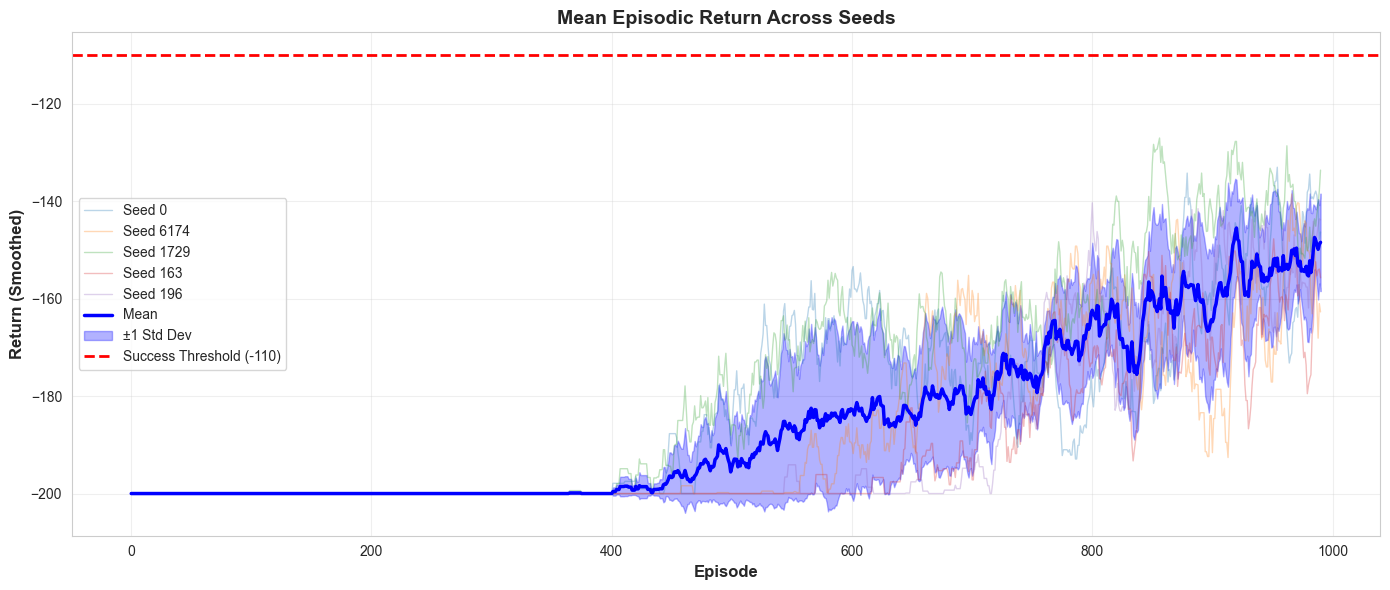

In [27]:
def plot_mean_episodic_return(results, window=10):
    """Plot mean episodic return across seeds"""
    plt.figure(figsize=(14, 6))
    
    # Prepare data
    all_returns = []
    max_len = max(len(r['episode_returns']) for r in results)
    
    for result in results:
        returns = result['episode_returns']
        # Smooth with moving average
        smoothed = np.convolve(returns, np.ones(window)/window, mode='valid')
        all_returns.append(smoothed)
    
    # Calculate mean and std
    min_len = min(len(r) for r in all_returns)
    all_returns_array = np.array([r[:min_len] for r in all_returns])
    mean_returns = np.mean(all_returns_array, axis=0)
    std_returns = np.std(all_returns_array, axis=0)
    
    episodes = np.arange(len(mean_returns))
    
    # Plot individual seeds (lighter)
    for i, result in enumerate(results):
        returns = result['episode_returns']
        smoothed = np.convolve(returns, np.ones(window)/window, mode='valid')
        plt.plot(smoothed, alpha=0.3, linewidth=1, label=f'Seed {result["seed"]}')
    
    # Plot mean with confidence interval
    plt.plot(episodes, mean_returns, 'b-', linewidth=2.5, label='Mean', zorder=10)
    plt.fill_between(episodes, mean_returns - std_returns, mean_returns + std_returns, 
                     alpha=0.3, color='blue', label='±1 Std Dev')
    
    # Success threshold line
    plt.axhline(y=SUCCESS_THRESHOLD, color='r', linestyle='--', 
                linewidth=2, label=f'Success Threshold ({SUCCESS_THRESHOLD})')
    
    plt.xlabel('Episode', fontsize=12, fontweight='bold')
    plt.ylabel('Return (Smoothed)', fontsize=12, fontweight='bold')
    plt.title('Mean Episodic Return Across Seeds', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('mean_episodic_return.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_mean_episodic_return(results, window=10)

Steps to Succes Threshold

Visualizes sample efficiency.

- Each bar: Total environment steps needed to reach success threshold
- Lower is better: Fewer steps = faster learning
- Red line: Average across all successful seeds
- Missing bars: Seeds that never reached threshold
- Purpose: Shows how quickly the algorithm learns to solve the task

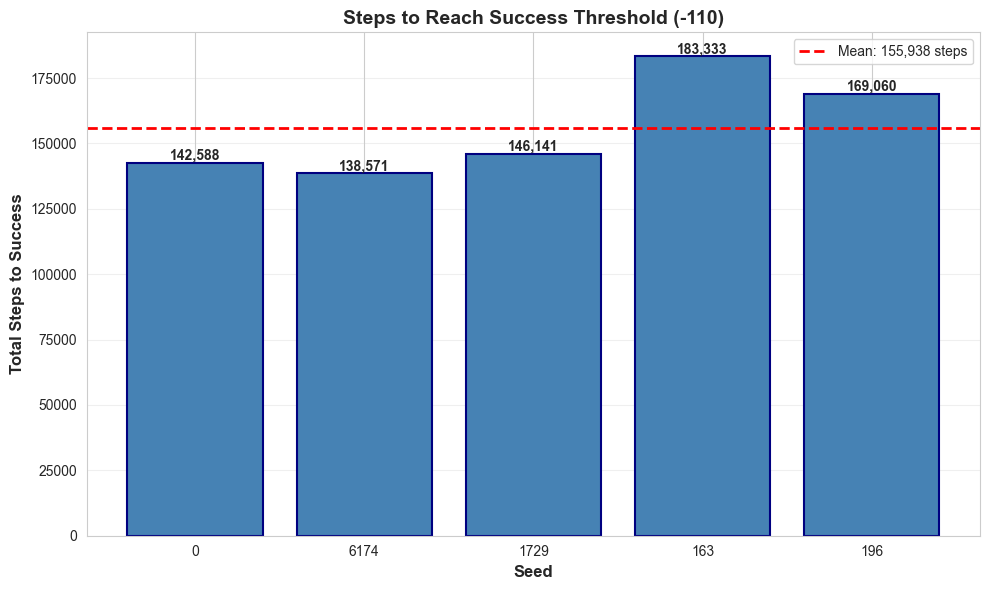

In [28]:
def plot_steps_to_success(results):
    """Plot steps to reach success threshold"""
    plt.figure(figsize=(10, 6))
    
    seeds = [r['seed'] for r in results]
    steps = [r['steps_to_success'] if r['steps_to_success'] is not None else np.nan 
             for r in results]
    
    # Filter out NaN values
    valid_seeds = [s for s, step in zip(seeds, steps) if not np.isnan(step)]
    valid_steps = [step for step in steps if not np.isnan(step)]
    
    if valid_steps:
        # Bar plot
        bars = plt.bar(range(len(valid_seeds)), valid_steps, color='steelblue', 
                       edgecolor='navy', linewidth=1.5)
        
        # Add value labels on bars
        for i, (bar, step) in enumerate(zip(bars, valid_steps)):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(step):,}',
                    ha='center', va='bottom', fontweight='bold')
        
        # Mean line
        mean_steps = np.mean(valid_steps)
        plt.axhline(y=mean_steps, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {int(mean_steps):,} steps')
        
        plt.xlabel('Seed', fontsize=12, fontweight='bold')
        plt.ylabel('Total Steps to Success', fontsize=12, fontweight='bold')
        plt.title(f'Steps to Reach Success Threshold ({SUCCESS_THRESHOLD})', 
                 fontsize=14, fontweight='bold')
        plt.xticks(range(len(valid_seeds)), valid_seeds)
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'No seeds reached success threshold', 
                ha='center', va='center', fontsize=14, transform=plt.gca().transAxes)
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('steps_to_success.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_steps_to_success(results)

Stability  -- Variance Reward Oscillations

Top plot: Shows reward variance over time.

- Rolling variance: Variance of returns in last 50 episodes
- High variance: Unstable, inconsistent performance
- Low variance: Stable, predictable performance
- Ideal: Variance decreases as agent learns (becomes more consistent)

Shows how much returns jump between episodes.

- Oscillation: |Return(t) - Return(t-1)|
- High oscillation: Performance jumps around unpredictably
- Low oscillation: Smooth, gradual improvement
- Both plots together: Comprehensive view of training stability

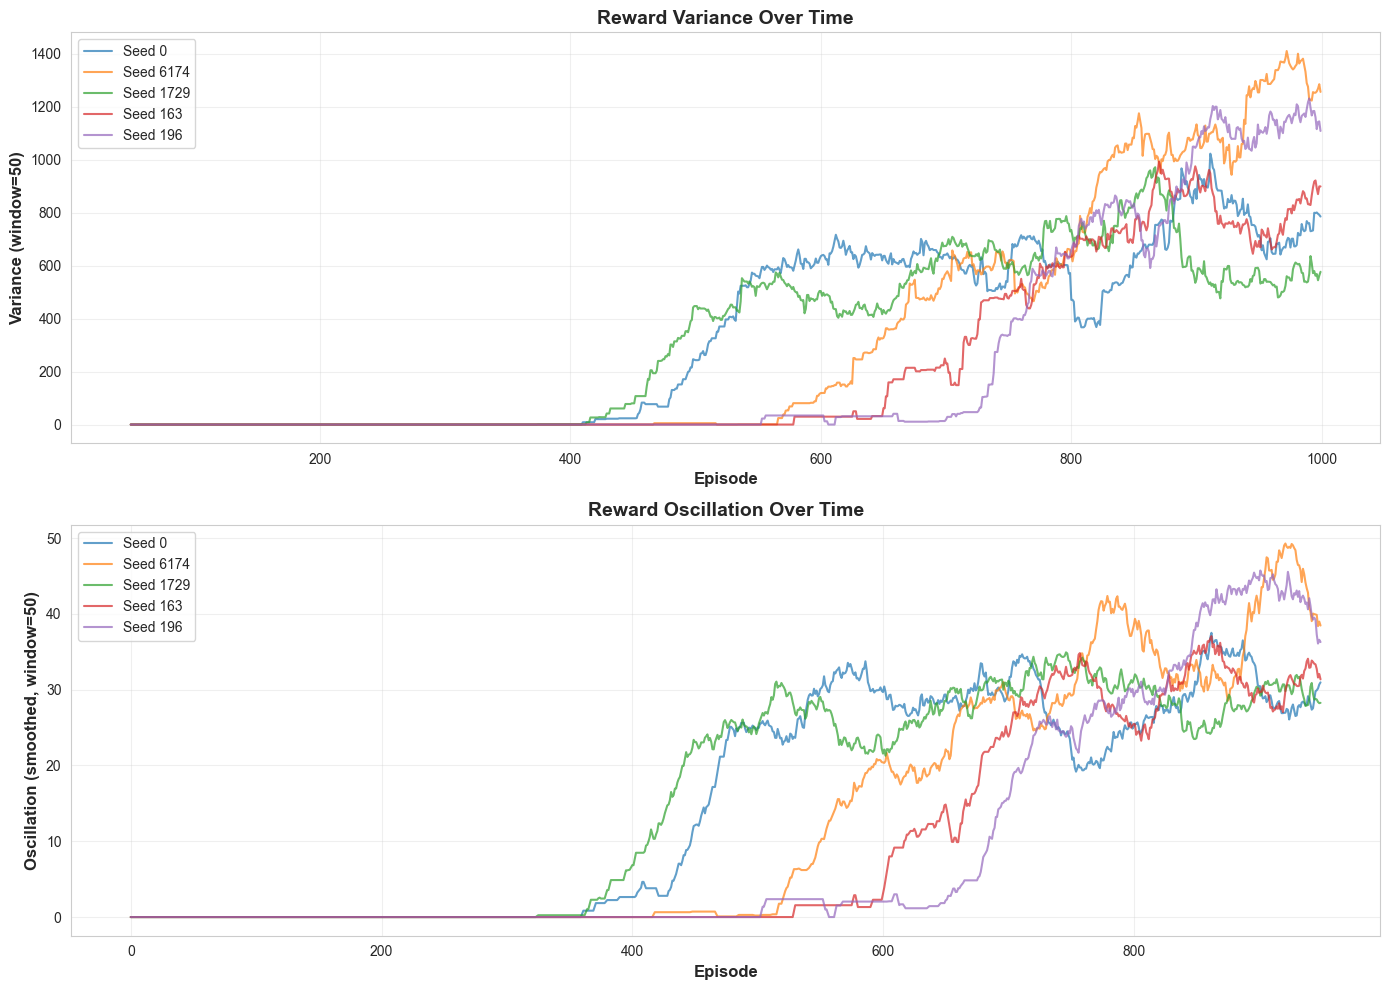

In [29]:
def plot_stability(results, window=50):
    """Plot stability metrics: variance and reward oscillation"""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Calculate rolling variance for each seed
    for result in results:
        returns = np.array(result['episode_returns'])
        
        # Rolling variance
        rolling_var = []
        for i in range(len(returns) - window + 1):
            rolling_var.append(np.var(returns[i:i+window]))
        
        episodes = np.arange(window-1, len(returns))
        axes[0].plot(episodes, rolling_var, alpha=0.7, label=f'Seed {result["seed"]}')
    
    axes[0].set_xlabel('Episode', fontsize=12, fontweight='bold')
    axes[0].set_ylabel(f'Variance (window={window})', fontsize=12, fontweight='bold')
    axes[0].set_title('Reward Variance Over Time', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Calculate reward oscillation (absolute difference between consecutive episodes)
    for result in results:
        returns = np.array(result['episode_returns'])
        oscillation = np.abs(np.diff(returns))
        
        # Smooth oscillation
        smoothed_osc = np.convolve(oscillation, np.ones(window)/window, mode='valid')
        episodes = np.arange(len(smoothed_osc))
        
        axes[1].plot(episodes, smoothed_osc, alpha=0.7, label=f'Seed {result["seed"]}')
    
    axes[1].set_xlabel('Episode', fontsize=12, fontweight='bold')
    axes[1].set_ylabel(f'Oscillation (smoothed, window={window})', 
                      fontsize=12, fontweight='bold')
    axes[1].set_title('Reward Oscillation Over Time', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('stability_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_stability(results, window=50)

Performance Drop - Robusteness Degradation Curve 

formula : 
$$
\text{Performance Drop} = \frac{R_0 - R_p}{R_0}
$$

where:
- $R_0$ = mean return at 0% stochasticity  
- $R_p$ = mean return at stochasticity level $p$


**And since here we are still at level 0% of Stochasity its just $R_0$**

Convergence Reliability

- Shows what percentage of seeds successfully converged.

    - Green bar: Seeds that reached success threshold
    - Red bar: Seeds that failed to converge
    - Purpose: Evaluates algorithm reliability (does it consistently work?)

- Histogram of final performance.

    - Distribution: Shows spread of final returns across all seeds
    - Red line: Success threshold
    - Green line: Mean performance
    - Shape tells story:

        - Narrow peak: Consistent results
        - Wide spread: High variability
        - Bimodal: Some seeds succeed, others fail completely


- Color-coded learning curves.

    - Green curves: Seeds that converged (✓)
    - Red curves: Seeds that failed (✗)
    - Visual comparison: Can you see patterns? Do failed seeds plateau early? Do successful ones follow similar trajectories?



C:\Users\akebl\AppData\Local\Temp\ipykernel_20988\3051795853.py:81: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\akebl\AppData\Local\Temp\ipykernel_20988\3051795853.py:82: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  plt.savefig('convergence_reliability.png', dpi=300, bbox_inches='tight')
c:\Users\akebl\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10007 (\N{BALLOT X}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


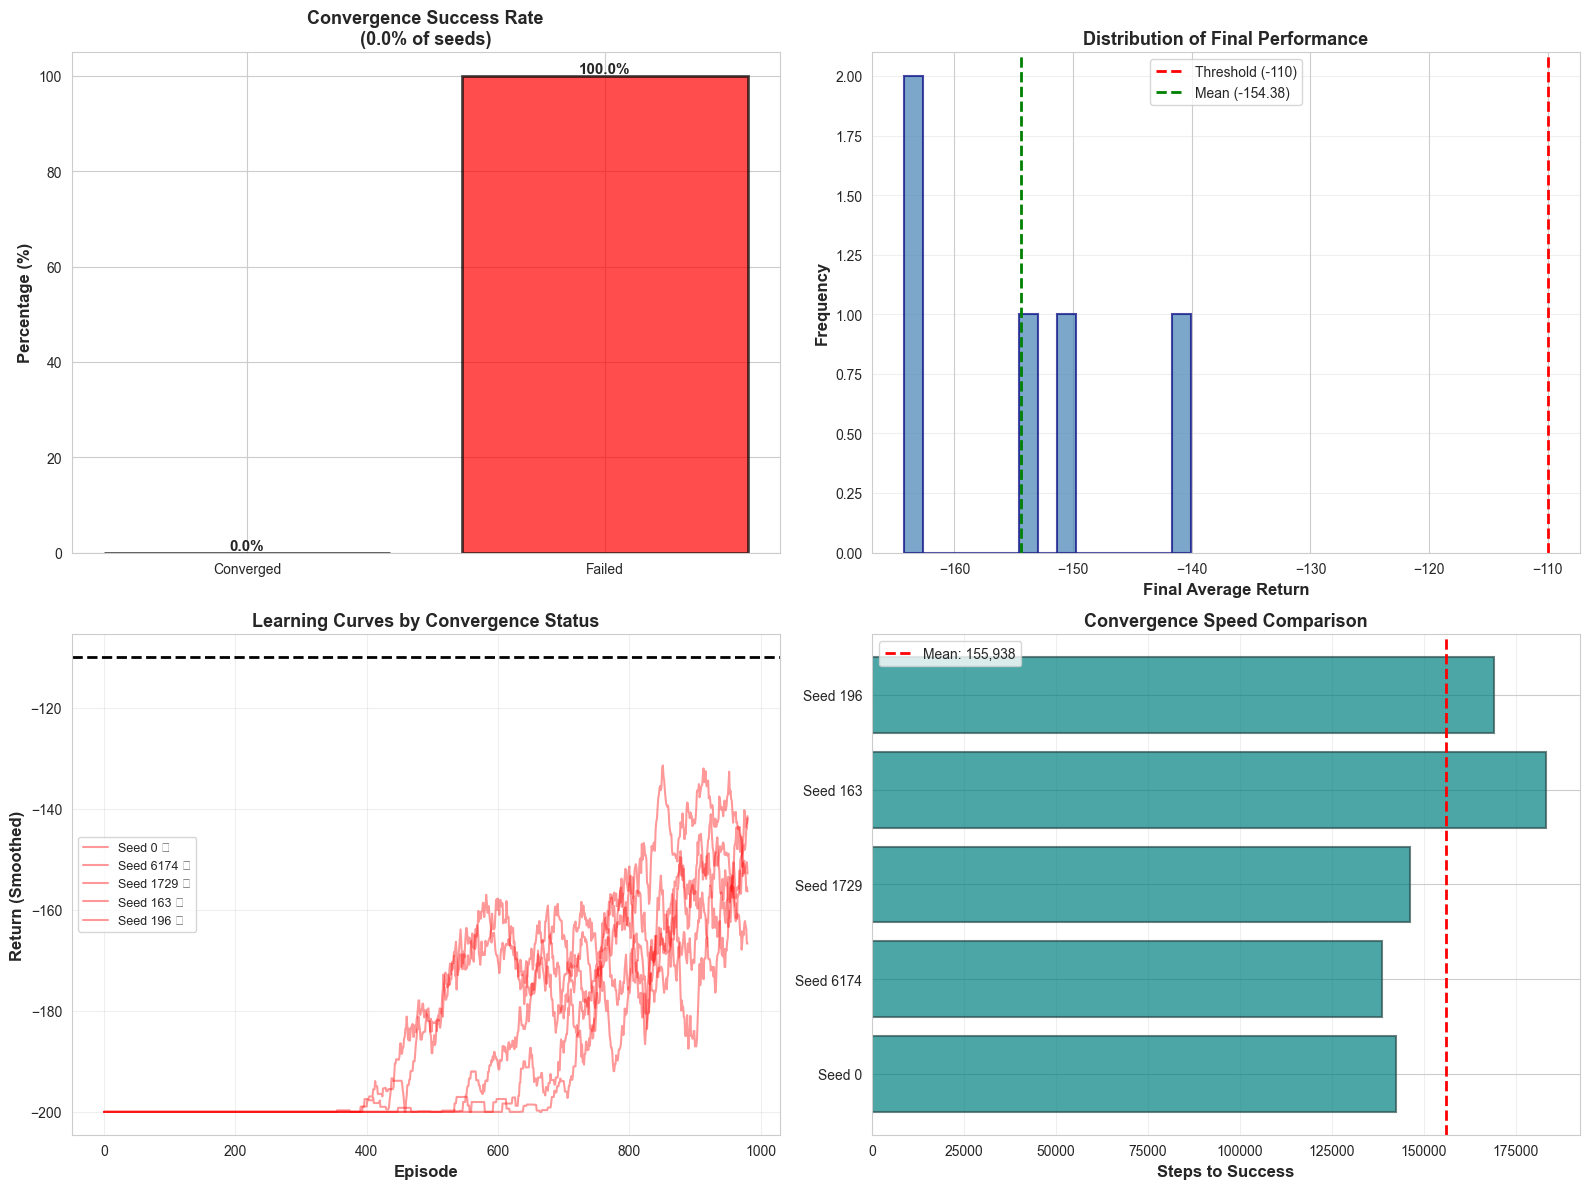

In [30]:
def plot_convergence_reliability(results, threshold=-110):
    """Plot convergence reliability metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Success rate
    ax = axes[0, 0]
    success_rate = sum(1 for r in results if r['final_avg_return'] >= threshold) / len(results)
    categories = ['Converged', 'Failed']
    values = [success_rate * 100, (1 - success_rate) * 100]
    colors = ['green', 'red']
    
    bars = ax.bar(categories, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Convergence Success Rate\n({success_rate:.1%} of seeds)', 
                fontsize=13, fontweight='bold')
    ax.set_ylim([0, 105])
    
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{val:.1f}%', ha='center', va='bottom', 
               fontsize=11, fontweight='bold')
    
    # 2. Final performance distribution
    ax = axes[0, 1]
    final_returns = [r['final_avg_return'] for r in results]
    ax.hist(final_returns, bins=15, color='steelblue', alpha=0.7, 
            edgecolor='navy', linewidth=1.5)
    ax.axvline(threshold, color='red', linestyle='--', linewidth=2, 
              label=f'Threshold ({threshold})')
    ax.axvline(np.mean(final_returns), color='green', linestyle='--', 
              linewidth=2, label=f'Mean ({np.mean(final_returns):.2f})')
    ax.set_xlabel('Final Average Return', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title('Distribution of Final Performance', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 3. Learning curves comparison
    ax = axes[1, 0]
    for result in results:
        returns = result['episode_returns']
        smoothed = np.convolve(returns, np.ones(20)/20, mode='valid')
        converged = result['final_avg_return'] >= threshold
        color = 'green' if converged else 'red'
        alpha = 0.8 if converged else 0.4
        ax.plot(smoothed, color=color, alpha=alpha, linewidth=1.5,
               label=f'Seed {result["seed"]} {"✓" if converged else "✗"}')
    
    ax.axhline(threshold, color='black', linestyle='--', linewidth=2)
    ax.set_xlabel('Episode', fontsize=12, fontweight='bold')
    ax.set_ylabel('Return (Smoothed)', fontsize=12, fontweight='bold')
    ax.set_title('Learning Curves by Convergence Status', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # 4. Convergence speed (steps to success)
    ax = axes[1, 1]
    seeds_with_success = [(r['seed'], r['steps_to_success']) 
                          for r in results if r['steps_to_success'] is not None]
    
    if seeds_with_success:
        seeds, steps = zip(*seeds_with_success)
        bars = ax.barh(range(len(seeds)), steps, color='teal', 
                       alpha=0.7, edgecolor='darkslategray', linewidth=1.5)
        ax.set_yticks(range(len(seeds)))
        ax.set_yticklabels([f'Seed {s}' for s in seeds])
        ax.set_xlabel('Steps to Success', fontsize=12, fontweight='bold')
        ax.set_title('Convergence Speed Comparison', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')
        
        # Add mean line
        mean_steps = np.mean(steps)
        ax.axvline(mean_steps, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {int(mean_steps):,}')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No convergence data available', 
               ha='center', va='center', fontsize=12, transform=ax.transAxes)
    
    plt.tight_layout()
    plt.savefig('convergence_reliability.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_convergence_reliability(results, threshold=SUCCESS_THRESHOLD)

Summary Stats

1. **Mean Episodic Return:** Does the agent learn? How fast? How consistently across seeds?
2. **Steps to Success:** Sample efficiency - how many experiences needed to learn?
3. **Stability:** Is training smooth or erratic? Does it stabilize over time?
4. **Robustness Degradation:** How well does the learned policy handle noise/perturbations?
5. **Convergence Reliability:** How many seeds succeed? Is the algorithm reliable?

Together, these give a **comprehensive evaluation** of your DQN implementation beyond just "did it work?"

In [31]:
def print_summary_statistics(results):
    """Print comprehensive summary statistics"""
    print("\n" + "="*70)
    print(" "*20 + "TRAINING SUMMARY STATISTICS")
    print("="*70)
    
    final_returns = [r['final_avg_return'] for r in results]
    steps_to_success = [r['steps_to_success'] for r in results 
                       if r['steps_to_success'] is not None]
    
    print(f"\nNumber of seeds: {len(results)}")
    print(f"\nFinal Average Returns:")
    print(f"  Mean:   {np.mean(final_returns):.2f}")
    print(f"  Std:    {np.std(final_returns):.2f}")
    print(f"  Min:    {np.min(final_returns):.2f}")
    print(f"  Max:    {np.max(final_returns):.2f}")
    print(f"  Median: {np.median(final_returns):.2f}")
    
    success_rate = sum(1 for r in final_returns if r >= SUCCESS_THRESHOLD) / len(results)
    print(f"\nConvergence Rate: {success_rate:.1%} ({int(success_rate*len(results))}/{len(results)} seeds)")
    
    if steps_to_success:
        print(f"\nSteps to Success (for converged seeds):")
        print(f"  Mean:   {np.mean(steps_to_success):,.0f}")
        print(f"  Std:    {np.std(steps_to_success):,.0f}")
        print(f"  Min:    {np.min(steps_to_success):,.0f}")
        print(f"  Max:    {np.max(steps_to_success):,.0f}")
    
    print("\n" + "="*70)
    print("\nPer-Seed Results:")
    print("-"*70)
    print(f"{'Seed':<10} {'Final Avg Return':<20} {'Steps to Success':<20} {'Status'}")
    print("-"*70)
    for result in results:
        status = "✓ Converged" if result['final_avg_return'] >= SUCCESS_THRESHOLD else "✗ Failed"
        steps = f"{result['steps_to_success']:,}" if result['steps_to_success'] else "N/A"
        print(f"{result['seed']:<10} {result['final_avg_return']:<20.2f} {steps:<20} {status}")
    print("="*70)

print_summary_statistics(results)


                    TRAINING SUMMARY STATISTICS

Number of seeds: 5

Final Average Returns:
  Mean:   -154.38
  Std:    8.92
  Min:    -164.23
  Max:    -140.09
  Median: -153.58

Convergence Rate: 0.0% (0/5 seeds)

Steps to Success (for converged seeds):
  Mean:   155,939
  Std:    17,312
  Min:    138,571
  Max:    183,333


Per-Seed Results:
----------------------------------------------------------------------
Seed       Final Avg Return     Steps to Success     Status
----------------------------------------------------------------------
0          -150.60              142,588              ✗ Failed
6174       -164.23              138,571              ✗ Failed
1729       -140.09              146,141              ✗ Failed
163        -163.40              183,333              ✗ Failed
196        -153.58              169,060              ✗ Failed
